### Biblioteki

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import zstandard as zstd
from tqdm import tqdm


from transformers import pipeline, AutoTokenizer
from langdetect import detect, LangDetectException

### Recenzje

In [2]:
REVIEWS_PATH = '/home/psik/GITHUB/IUM/IUM-long-stay-insights/data/raw/v2/reviews.csv.zst'

In [33]:
def create_dataframe_from_csv_zst(filepath: str) -> pd.DataFrame:
    dctx = zstd.ZstdDecompressor()
    with open(filepath, 'rb') as compressed:
        with dctx.stream_reader(compressed) as reader:
            decompressed = io.TextIOWrapper(reader, encoding='utf-8')
            df = pd.read_csv(
                decompressed,
                low_memory=True
            )
    return df

def compress_dataframe_to_zst(df: pd.DataFrame, output_file: str, compression_level: int = 3) -> None:
    cctx = zstd.ZstdCompressor(level=compression_level)
    csv_bytes = df.to_csv(index=False).encode('utf-8')
    compressed_data = cctx.compress(csv_bytes)
    with open(output_file, 'wb') as f:
        f.write(compressed_data)
    print(f"Compressed to file {output_file} with size {len(compressed_data)} bytes")

In [ ]:
reviews_dataframe = create_dataframe_from_csv_zst(REVIEWS_PATH)
reviews_dataframe.head(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,27262,2362781,2012-09-21,3415451,Sian,The trip was amazing!! Emmanouil was a brillia...
1,27262,31962656,2015-05-12,30220642,Ace,Great host and lovely flat we stayed here for ...
2,27262,35610419,2015-06-20,35701367,Carole,"Manos is a wonderful host, he is very helpful ..."
3,27262,53790022,2015-11-12,47390335,Κωνσταντίνα,Το σπίτι του κυρίου Εμμανουηλ ηταν πολύ ωραιο ...
4,27262,56342611,2015-12-12,31391271,Sarah,"Manos made us feel very welcome, showed us aro..."


In [36]:
# empty comments
empty_comments = reviews_dataframe[reviews_dataframe['comments'].isna()]
print(f"Number of empty comments: {len(empty_comments)}")

Number of empty comments: 156


### Analiza języka

In [12]:
random_reviews = reviews_dataframe.sample(5)

for index, row in random_reviews.iterrows():
    print(f"Review : {row['comments']}")

Review : The apartment is very clean has everything you need.
Review : Pros: great location, clean, great water pressure, nice view.<br/>Cons: water pump under the sink is extremely loud when it’s pumping water. Air conditioning in the larger bedroom doesn’t cool as well as the other two units in the condo. Lobby/elevator have a very unpleasant smell.(no fault of the host)
Review : estancia agradable. Walter resultó ser excelente anfitrión. muy buena ubicación,  a dos cuadras de la plaza mayor.
Review : It was one of my best stays, the host was very kind and understanding, I had everything I needed, the location is also fine
Review : Nice. Good place to stay. Many restaurant nearby. You can reach there by metro and bus very easily.


- Widać, że opinie, są w różnych językach. Rozpoznawanie sentymentu dla, każdego z nich mogłoby być wymagające, dlatego postaramy się przeanalizować, te będące w języku angielskim

#### Model (langdetect - lekka biblioteka na podstawie Google Language Detection)

In [30]:
for index, row in random_reviews.iterrows():
    text = row['comments']

    result = detect(text)
    print(f"Review : {text}")
    print(f"Language : {result}")

Review : The apartment is very clean has everything you need.
Language : en
Review : Pros: great location, clean, great water pressure, nice view.<br/>Cons: water pump under the sink is extremely loud when it’s pumping water. Air conditioning in the larger bedroom doesn’t cool as well as the other two units in the condo. Lobby/elevator have a very unpleasant smell.(no fault of the host)
Language : en
Review : estancia agradable. Walter resultó ser excelente anfitrión. muy buena ubicación,  a dos cuadras de la plaza mayor.
Language : es
Review : It was one of my best stays, the host was very kind and understanding, I had everything I needed, the location is also fine
Language : en
Review : Nice. Good place to stay. Many restaurant nearby. You can reach there by metro and bus very easily.
Language : en


#### Dodanie rodzaju języka, do datasetu

In [40]:
def detect_language(text: str) -> str:
    try:
        text = text.strip()
        if not text or len(text) < 10:
            return 'unknown'
        return detect(text)
    except LangDetectException:
        return 'unknown'

def add_language_column(df: pd.DataFrame) -> pd.DataFrame:
    tqdm.pandas(desc="Detecting languages")
    df['language'] = df['comments'].progress_apply(lambda x: detect_language(x) if pd.notnull(x) else 'unknown')
    return df


add_language_column(reviews_dataframe)

Detecting languages: 100%|██████████| 1982822/1982822 [1:33:50<00:00, 352.14it/s]


,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,27262,2362781,2012-09-21,3415451,Sian,The trip was amazing!! Emmanouil was a brillia...,en
1,27262,31962656,2015-05-12,30220642,Ace,Great host and lovely flat we stayed here for ...,en
2,27262,35610419,2015-06-20,35701367,Carole,"Manos is a wonderful host, he is very helpful ...",en
3,27262,53790022,2015-11-12,47390335,Κωνσταντίνα,Το σπίτι του κυρίου Εμμανουηλ ηταν πολύ ωραιο ...,el
4,27262,56342611,2015-12-12,31391271,Sarah,"Manos made us feel very welcome, showed us aro...",en
...,...,...,...,...,...,...,...
1982817,1364616759503109256,1368127111176342942,2025-03-02,368146996,Clémentine,"Très bon séjour chez Juan, le logement était p...",fr
1982818,1365007887657848515,1370244234430465527,2025-03-05,283312107,Hernan Enrique,Recomendable para una persona que quiere hacer...,es
1982819,1365007887657848515,1373818429800403177,2025-03-10,184521825,Carlos,"Es una Host súper amable, fue atenta en todo m...",es
1982820,1365635357360238932,1368103217874537823,2025-03-02,313257078,Yuet,很友善的房东，推荐,unknown


In [42]:
unique_languages = reviews_dataframe['language'].unique()
print(f"Unique languages detected: {unique_languages}")
print(f"Number of unique languages: {len(unique_languages)}")

Unique languages detected: ['en' 'el' 'it' 'fr' 'es' 'hu' 'unknown' 'nl' 'ro' 'af' 'de' 'zh-cn' 'pt'
 'ru' 'tr' 'ca' 'no' 'ko' 'sv' 'tl' 'pl' 'et' 'hr' 'vi' 'bg' 'fi' 'cs'
 'da' 'ja' 'ar' 'he' 'so' 'id' 'uk' 'zh-tw' 'sl' 'cy' 'sw' 'fa' 'sk' 'lv'
 'mk' 'lt' 'sq' 'th' 'ur' 'bn']
Number of unique languages: 47


In [44]:
for lang in unique_languages:
    count = len(reviews_dataframe[reviews_dataframe['language'] == lang])
    print(f"Language: {lang}, Count: {count}")

Language: en, Count: 1015319
Language: el, Count: 71712
Language: it, Count: 37961
Language: fr, Count: 137728
Language: es, Count: 518152
Language: hu, Count: 1232
Language: unknown, Count: 38423
Language: nl, Count: 12165
Language: ro, Count: 4819
Language: af, Count: 1107
Language: de, Count: 43176
Language: zh-cn, Count: 10718
Language: pt, Count: 40901
Language: ru, Count: 6548
Language: tr, Count: 4199
Language: ca, Count: 4961
Language: no, Count: 1538
Language: ko, Count: 8948
Language: sv, Count: 1575
Language: tl, Count: 730
Language: pl, Count: 4196
Language: et, Count: 233
Language: hr, Count: 628
Language: vi, Count: 135
Language: bg, Count: 297
Language: fi, Count: 1047
Language: cs, Count: 1470
Language: da, Count: 2306
Language: ja, Count: 1433
Language: ar, Count: 777
Language: he, Count: 4381
Language: so, Count: 687
Language: id, Count: 347
Language: uk, Count: 536
Language: zh-tw, Count: 644
Language: sl, Count: 311
Language: cy, Count: 284
Language: sw, Count: 170


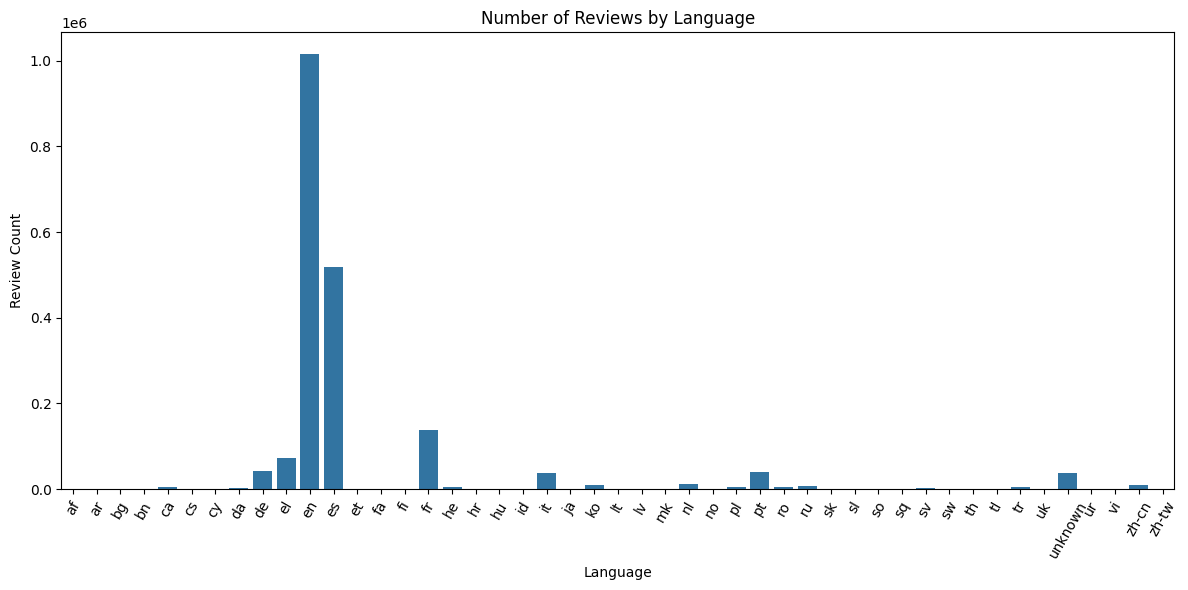

In [ ]:
lang_count = reviews_dataframe.groupby('language').size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(data=lang_count, x='language', y='count')
plt.title('Number of Reviews by Language')
plt.xlabel('Language')
plt.ylabel('Review Count')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [52]:
language_map = {"af": "Afrikaans", "ar": "Arabic", "bg": "Bulgarian", "bn": "Bengali", "ca": "Catalan", "cs": "Czech", "cy": "Welsh", "da": "Danish", "de": "German", "el": "Greek", "en": "English", "es": "Spanish", "et": "Estonian", "fa": "Persian (Farsi)", "fi": "Finnish", "fr": "French", "he": "Hebrew", "hr": "Croatian", "hu": "Hungarian", "id": "Indonesian", "it": "Italian", "ja": "Japanese", "ko": "Korean", "lt": "Lithuanian", "lv": "Latvian", "mk": "Macedonian", "nl": "Dutch", "no": "Norwegian", "pl": "Polish", "pt": "Portuguese", "ro": "Romanian", "ru": "Russian", "sk": "Slovak", "sl": "Slovenian", "so": "Somali", "sq": "Albanian", "sv": "Swedish", "sw": "Swahili", "th": "Thai", "tl": "Tagalog", "tr": "Turkish", "uk": "Ukrainian", "ur": "Urdu", "vi": "Vietnamese", "zh-cn": "Chinese (Simplified)", "zh-tw": "Chinese (Traditional)", "unknown": "Unknown"}

abbriviations_df = pd.DataFrame(list(language_map.items()), columns=['language', 'language_full'])
abbriviations_df.head(5)

,language,language_full
0,af,Afrikaans
1,ar,Arabic
2,bg,Bulgarian
3,bn,Bengali
4,ca,Catalan


- Najwięcej opini mamy w języku angielskim, hiszpańskim oraz francuskim
- Na potrzeby analizy, skupimy się w pierwszej kolejności na opiniach po angielsku, ponieważ posiadamy ich ponad 1 milion
- Jeśli próbka okaże się, za mała to rozważymy analizę, sentymentu pozostałych języków

### Analiza sentymentu

#### Model

In [61]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [56]:
english_samples = reviews_dataframe[reviews_dataframe['language'] == 'en'].sample(5)

In [57]:
for sample in english_samples['comments']:
    print(f"Sample: {sample}")
    sentiment = sentiment_pipeline(sample)
    print(f"Sentiment: {sentiment}")
    print("-" * 50)

Sample: Lovely place, practical, centrically located. And did I say quiet! You can get some shut-eye
Sentiment: [{'label': 'POSITIVE', 'score': 0.9989628791809082}]
--------------------------------------------------
Sample: Ricardo is a special host. He expect us with chocolates and he wrote us tips for visiting the city and restaurants. The house is exactly the same in the pictures, it's wonderful and it's right in the centre. You can walk by foot in all places in Madrid. Thank you for a special weekend Ricardo!
Sentiment: [{'label': 'POSITIVE', 'score': 0.9998581409454346}]
--------------------------------------------------
Sample: The apartment is really good! The main bedroom is big and has a balcony to the street. The second bedroom is a bit email, but it fits 1 person well. The kitchen is functional and my only observation is regarding the bathroom that is really small. In terms of location, it's just perfect! Close to Puerta del Sol, you can walk to the main attractions or easly

#### Język angielski

In [54]:
english_reviews = reviews_dataframe[reviews_dataframe['language'] == 'en']
print(f"Number of English reviews: {len(english_reviews)}")
english_reviews.head(5)

Number of English reviews: 1015319


,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,27262,2362781,2012-09-21,3415451,Sian,The trip was amazing!! Emmanouil was a brillia...,en
1,27262,31962656,2015-05-12,30220642,Ace,Great host and lovely flat we stayed here for ...,en
2,27262,35610419,2015-06-20,35701367,Carole,"Manos is a wonderful host, he is very helpful ...",en
4,27262,56342611,2015-12-12,31391271,Sarah,"Manos made us feel very welcome, showed us aro...",en
5,27262,56699344,2015-12-16,28705058,Ioannis,The apartment is well-equipped and beautifully...,en


In [67]:
def chunk_text(text: str, max_length: int = 256) -> list:
    text = text.strip()
    text = tokenizer.encode(text, add_special_tokens=False)

    chunks = []
    for i in range(0, len(text), max_length):
        chunk = text[i:i + max_length]
        chunks.append(tokenizer.decode(chunk, skip_special_tokens=True))
    return chunks

def analyze_sentiment_from_chunks(text: str) -> str:
    chunks = chunk_text(text)
    results = sentiment_pipeline(chunks)
    sentiments = [result['label'] for result in results]
    return max(set(sentiments), key=sentiments.count)

def add_sentiment_column(df: pd.DataFrame) -> pd.DataFrame:
    tqdm.pandas(desc="Calculating sentiment")
    df['sentiment_en'] = df['comments'].progress_apply(lambda x: analyze_sentiment_from_chunks(x) if pd.notnull(x) else 'unknown')
    return df

add_sentiment_column(english_reviews)

Calculating sentiment: 100%|██████████| 1015319/1015319 [3:29:35<00:00, 80.74it/s]  
/tmp/ipykernel_415/865027500.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_en'] = df['comments'].progress_apply(lambda x: analyze_sentiment_from_chunks(x) if pd.notnull(x) else 'unknown')


,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment_en
0,27262,2362781,2012-09-21,3415451,Sian,The trip was amazing!! Emmanouil was a brillia...,en,POSITIVE
1,27262,31962656,2015-05-12,30220642,Ace,Great host and lovely flat we stayed here for ...,en,POSITIVE
2,27262,35610419,2015-06-20,35701367,Carole,"Manos is a wonderful host, he is very helpful ...",en,POSITIVE
4,27262,56342611,2015-12-12,31391271,Sarah,"Manos made us feel very welcome, showed us aro...",en,POSITIVE
5,27262,56699344,2015-12-16,28705058,Ioannis,The apartment is well-equipped and beautifully...,en,POSITIVE
...,...,...,...,...,...,...,...,...
1982796,1354941531245470417,1368100220464187776,2025-03-02,163472275,Filipa,Cindy was super nice and friendly!!<br/>The ho...,en,POSITIVE
1982800,1354975035399289340,1365910400932659169,2025-02-27,29044731,Edmundo,Great place! Very central located and beautifu...,en,POSITIVE
1982807,1355256529484933767,1370965334122735795,2025-03-06,216066594,Aleksander,I had a really great time in Pierina's apartme...,en,POSITIVE
1982808,1366853173044267909,1369547148534551021,2025-03-04,680174488,Ampofo,he is good for his reception service,en,POSITIVE


In [8]:
positive_comments_amount = len(english_reviews[english_reviews['sentiment_en'] == 'POSITIVE'])
negative_comments_amount = len(english_reviews[english_reviews['sentiment_en'] == 'NEGATIVE'])
print(f"Positive comments: {positive_comments_amount}")
print(f"Negative comments: {negative_comments_amount}")

Positive comments: 968304
Negative comments: 47015


#### Zapisanie plików

In [70]:
# save english comments to csv
english_reviews.to_csv('../data/processed/english_reviews.csv', index=False)
# save reviews_dataframe to csv
reviews_dataframe.to_csv('../data/processed/reviews_dataframe.csv', index=False)

In [4]:
english_reviews = pd.read_csv('../data/processed/english_reviews.csv')
reviews_dataframe = pd.read_csv('../data/processed/reviews_dataframe.csv')

In [5]:
print(f"English reviews shape: {english_reviews.shape}")
display(english_reviews.head(5))

English reviews shape: (1015319, 8)


,listing_id,id,date,reviewer_id,reviewer_name,comments,language,sentiment_en
0,27262,2362781,2012-09-21,3415451,Sian,The trip was amazing!! Emmanouil was a brillia...,en,POSITIVE
1,27262,31962656,2015-05-12,30220642,Ace,Great host and lovely flat we stayed here for ...,en,POSITIVE
2,27262,35610419,2015-06-20,35701367,Carole,"Manos is a wonderful host, he is very helpful ...",en,POSITIVE
3,27262,56342611,2015-12-12,31391271,Sarah,"Manos made us feel very welcome, showed us aro...",en,POSITIVE
4,27262,56699344,2015-12-16,28705058,Ioannis,The apartment is well-equipped and beautifully...,en,POSITIVE


In [6]:
print(f"Reviews shape: {reviews_dataframe.shape}")
display(reviews_dataframe.head(5))

Reviews shape: (1982822, 7)


,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,27262,2362781,2012-09-21,3415451,Sian,The trip was amazing!! Emmanouil was a brillia...,en
1,27262,31962656,2015-05-12,30220642,Ace,Great host and lovely flat we stayed here for ...,en
2,27262,35610419,2015-06-20,35701367,Carole,"Manos is a wonderful host, he is very helpful ...",en
3,27262,53790022,2015-11-12,47390335,Κωνσταντίνα,Το σπίτι του κυρίου Εμμανουηλ ηταν πολύ ωραιο ...,el
4,27262,56342611,2015-12-12,31391271,Sarah,"Manos made us feel very welcome, showed us aro...",en


#### Wiarygodność sentymentu

In [14]:
random_sentiment = english_reviews.sample(8)
for index, row in random_sentiment.iterrows():
    print(f"Review : {row['comments']}")
    print(f"Sentiment : {row['sentiment_en']}")
    print("-" * 50)

Review : If you are on a budget and you want to be in the center, this is the place for you.
Sentiment : POSITIVE
--------------------------------------------------
Review : Sokratis is a very polite and attentive host. His fast communication was a great lifesaver. The balcony and terrace of the house were great. We enjoyed the view. It was a 20-minute walk to central points such as the Acropolis. We did not use any metro or car. Thank you Sokratis.
Sentiment : POSITIVE
--------------------------------------------------
Review : Great value with a fantastic view
Sentiment : POSITIVE
--------------------------------------------------
Review : This modern apartment is in an extraordinary good condition. We also felt very secure in the quarter. Thanks!
Sentiment : POSITIVE
--------------------------------------------------
Review : The space was clean and the hospitality was great. The location is great and very metro accessible. Laurence and family was extremely accommodating and very qu

- Widać, że sentyment, niektórych opini jest dobrze rozpoznawany, aczkolwiek znajdują się przypadki, w których zdanie jest pozytywne a przypisana ocena jest negatywna

### Statystyki recenzji

In [19]:
total_comments = len(english_reviews)
positive_percentage = (positive_comments_amount / total_comments) * 100
negative_percentage = (negative_comments_amount / total_comments) * 100
print(f"Positive comments percentage: {positive_percentage:.2f}%")
print(f"Negative comments percentage: {negative_percentage:.2f}%")

Positive comments percentage: 95.37%
Negative comments percentage: 4.63%


/tmp/ipykernel_353/3245099706.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sentiment', loc='upper right')


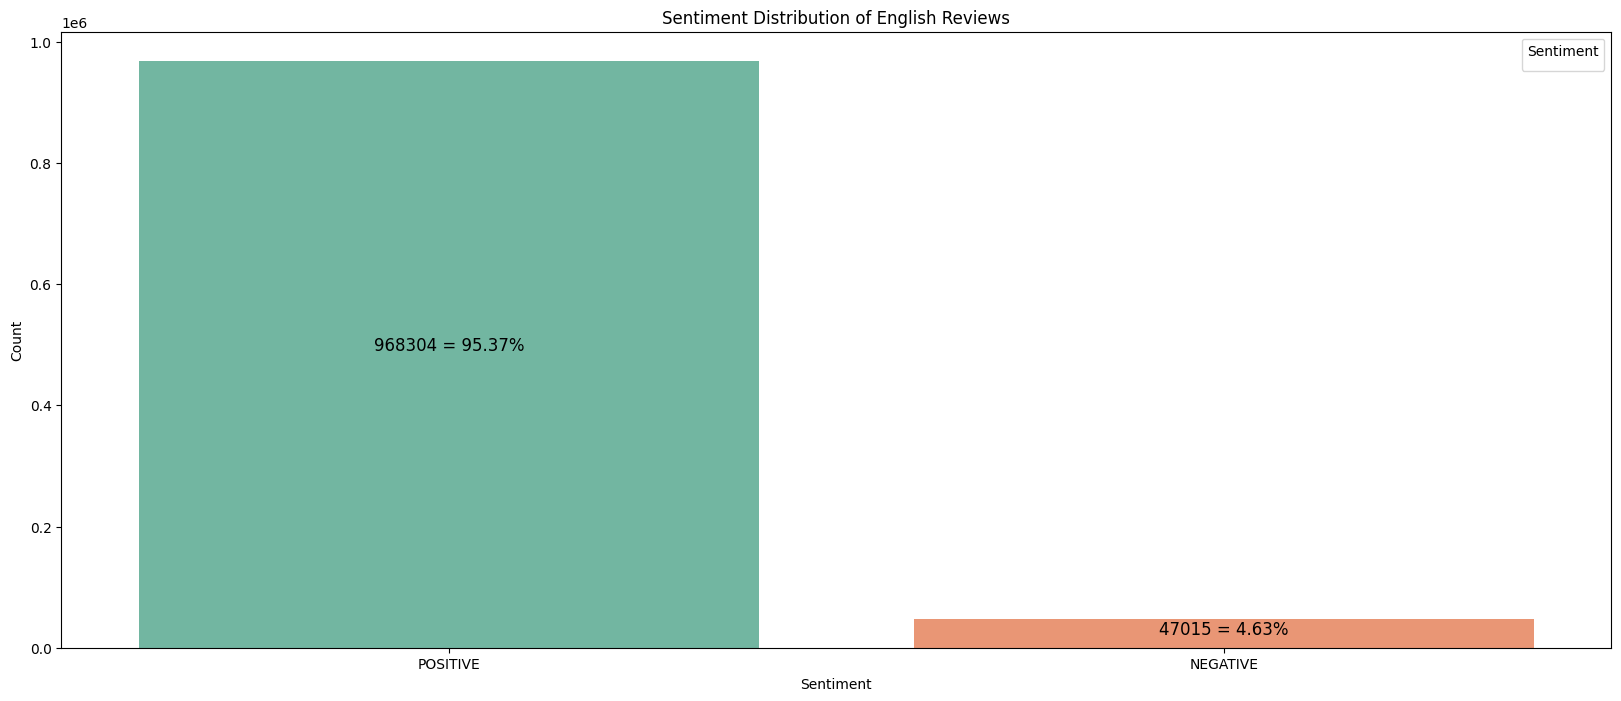

In [20]:
plt.figure(figsize=(20, 8))
sns.countplot(data=english_reviews, x='sentiment_en', palette='Set2', hue='sentiment_en')
plt.title('Sentiment Distribution of English Reviews')
plt.text(0, positive_comments_amount // 2, f'{positive_comments_amount} = {positive_percentage:.2f}%', ha='center', va='bottom', fontsize=12)
plt.text(1, negative_comments_amount // 3, f'{negative_comments_amount} = {negative_percentage:.2f}%', ha='center', va='bottom', fontsize=12)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right')

#### Liczba recenzji na oferte

In [25]:
reviews_per_listing = reviews_dataframe.groupby('listing_id').size().reset_index(name='total_reviews')
print(f"Number of listings with reviews: {len(reviews_per_listing)}")
reviews_per_listing.head(5)

Number of listings with reviews: 32420


,listing_id,total_reviews
0,21853,33
1,27262,29
2,30320,172
3,30959,8
4,33945,78


In [26]:
english_reviews_per_listing = english_reviews.groupby('listing_id').size().reset_index(name='total_english_reviews')
print(f"Number of listings with English reviews: {len(english_reviews_per_listing)}")
english_reviews_per_listing.head(5)

Number of listings with English reviews: 28575


,listing_id,total_english_reviews
0,21853,17
1,27262,17
2,30320,133
3,30959,4
4,33945,60


In [28]:
english_pos_neg = english_reviews.groupby(['listing_id', 'sentiment_en']).size().reset_index(name='count')

reshaped = english_pos_neg.pivot(index='listing_id', columns='sentiment_en', values='count').reset_index()
reshaped = reshaped.rename(columns={'POSITIVE': 'count_positive_english', 'NEGATIVE': 'count_negative_english'})
reshaped.fillna(0, inplace=True)

print(f"Reshaped DataFrame shape: {reshaped.shape}")
reshaped.head(5)

Reshaped DataFrame shape: (28575, 3)


sentiment_en,listing_id,count_negative_english,count_positive_english
0,21853,1.0,16.0
1,27262,0.0,17.0
2,30320,15.0,118.0
3,30959,0.0,4.0
4,33945,2.0,58.0


In [29]:
merged_reviews_statistics = pd.merge(
    reviews_per_listing,
    english_reviews_per_listing,
    on='listing_id',
    how='left'
)
merged_reviews_statistics = pd.merge(
    merged_reviews_statistics,
    reshaped,
    on='listing_id',
    how='left'
)
merged_reviews_statistics.fillna(0, inplace=True)
print(f"Merged DataFrame shape: {merged_reviews_statistics.shape}")
merged_reviews_statistics.head(5)

Merged DataFrame shape: (32420, 5)


,listing_id,total_reviews,total_english_reviews,count_negative_english,count_positive_english
0,21853,33,17.0,1.0,16.0
1,27262,29,17.0,0.0,17.0
2,30320,172,133.0,15.0,118.0
3,30959,8,4.0,0.0,4.0
4,33945,78,60.0,2.0,58.0


In [37]:
merged_reviews_statistics.sort_values(by='total_reviews', ascending=True).head(10)

,listing_id,total_reviews,total_english_reviews,count_negative_english,count_positive_english
32394,1360150258394293784,1,0.0,0.0,0.0
32395,1360216172951139981,1,1.0,0.0,1.0
32396,1360283669957519009,1,0.0,0.0,0.0
25545,1120031122531680720,1,0.0,0.0,0.0
25546,1120077951567864313,1,1.0,0.0,1.0
25551,1120131876740468160,1,1.0,0.0,1.0
30383,1262788213193849396,1,1.0,0.0,1.0
30386,1262805065517684702,1,0.0,0.0,0.0
2924,18001589,1,1.0,0.0,1.0
2928,18011722,1,0.0,0.0,0.0


In [38]:
lisitngs_without_english_reviews = merged_reviews_statistics[merged_reviews_statistics['total_english_reviews'] == 0]
print(f"Number of listings without English reviews: {len(lisitngs_without_english_reviews)}")

Number of listings without English reviews: 3845


#### Zapisanie do csv.zst

In [34]:
compress_dataframe_to_zst(
    merged_reviews_statistics,
    '../data/processed/merged_reviews_statistics.csv.zst'
)

Compressed to file ../data/processed/merged_reviews_statistics.csv.zst with size 367457 bytes


In [35]:
df = create_dataframe_from_csv_zst(
    '../data/processed/merged_reviews_statistics.csv.zst'
)

df.head(5)

,listing_id,total_reviews,total_english_reviews,count_negative_english,count_positive_english
0,21853,33,17.0,1.0,16.0
1,27262,29,17.0,0.0,17.0
2,30320,172,133.0,15.0,118.0
3,30959,8,4.0,0.0,4.0
4,33945,78,60.0,2.0,58.0
